In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter

import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
from pathlib import Path

# Configurable parts
SYMBOL = "USDJPY"
SAMPLE_TYPE = "time"
MINUTES = 5
EVENT_NAME = 'CUSUM_0.001'
LABEL_NAME = "TB"

START_DATE = "20240101"
END_DATE = "20241231"

# Build base name
RESAMPLED_NAME = f"{SYMBOL}-{MINUTES}m-{START_DATE}-{END_DATE}"

# Base directories
BASE_DIR = Path("../data")
RESAMPLED_DIR = BASE_DIR / "resampled"
LABEL_DIR = BASE_DIR / "labels"
PROCESSED_DIR = BASE_DIR / "processed"
NORMALIZED_DIR = BASE_DIR / "normalized"
DIRECTION_LABEL_DIR = LABEL_DIR / "direction_labels"
PREDICTION_DIR = BASE_DIR / "predictions"

# Final paths
PROCESSED_FILE_PATH = PROCESSED_DIR / f"{RESAMPLED_NAME}_FEATURES.pkl"
NORMALIZED_FILE_PATH = NORMALIZED_DIR / f"{RESAMPLED_NAME}-normalized.pkl"
DIRECTION_LABEL_FILE_PATH = DIRECTION_LABEL_DIR / f"{RESAMPLED_NAME}-{EVENT_NAME}-{LABEL_NAME}.pkl"
PREDICTION_FILE_PATH = PREDICTION_DIR / f"{RESAMPLED_NAME}-{EVENT_NAME}-{LABEL_NAME}.pkl"

In [4]:
SEQUENCE_LENGTH = 120
TIME_COLS = [
    # 'timestamp',
    "hour",
    "dow",
    "dom",
    "month",
    # "open",
    # "high",
    # "low",
    # "close",
]

In [5]:
FEATURES_COLS = [
    # Core price dynamics
    # "close", 
    "spread",
    # Returns
    "close_log_return", "close_fd_return",
    # Trend
    "EMA_5", "EMA_50",
    # Volatility
    "ATRr_60",
    # Momentum / Strength
    "RSI_14", "ADX_14", "DMP_14", "DMN_14",
    # Bollinger band position (multi-scale)
    "BBP_5_2.0_2.0", "BBP_10_2.0_2.0", "BBP_20_2.0_2.0",
    # MACD momentum
    "MACDh_8_17_9",
    # Time cyclicality
    "hour_sin", "hour_cos", "dow_sin", "dow_cos", "month_sin", "month_cos"
]


In [6]:
TARGET_COL = "bin_class"

In [19]:
MODEL_NAME = "transformer_classifier_USDJPY-5m-20240101-20241231-CUSUM_0.001-TB"
V_NUM = 1
MODEL_PATH = f'../lightning_logs/{MODEL_NAME}/version_{V_NUM}/checkpoints/best_checkpoint.ckpt'

In [20]:
SIDE_NAME = 'transformer_sides'

META_LABEL_DIR = BASE_DIR / "meta_labels"
META_LABEL_DIR.mkdir(parents=True, exist_ok=True)
META_LABEL_FILE_PATH = META_LABEL_DIR / f"{RESAMPLED_NAME}-{EVENT_NAME}-{SIDE_NAME}.pkl"

In [21]:
%%time
df = pd.read_pickle(PROCESSED_FILE_PATH)
labels_df = pd.read_pickle(DIRECTION_LABEL_FILE_PATH)

CPU times: user 3.02 ms, sys: 16.8 ms, total: 19.8 ms
Wall time: 16.8 ms


In [22]:
missing = labels_df.index.difference(df.index)
missing

DatetimeIndex([], dtype='datetime64[ns]', name='timestamp', freq=None)

### Load Model

In [23]:
from fxml.models.lstm_classifier.model import LSTMClassifierModule
from fxml.models.transformer_classifier.model import TransformerClassifierModule

In [24]:
model = TransformerClassifierModule.load_from_checkpoint(MODEL_PATH)


## Get Side from Trained Model

In [25]:
features = df[FEATURES_COLS]

In [26]:
features.shape

(73782, 20)

In [29]:
import pandas as pd
import numpy as np
import torch
from tqdm import tqdm


def extract_sequences(data: pd.DataFrame, t_events, lookback: int):
    """Extract valid sequences and events for batch processing."""
    sequences, valid_events = [], []
    data_values, data_index = data.values.astype(np.float32), data.index
    
    for t in t_events:
        try:
            if t in data_index:
                end_loc = data_index.get_loc(t)
                start_loc = end_loc - lookback
                if start_loc >= 0:
                    seq = data_values[start_loc:end_loc]
                    if len(seq) == lookback:
                        sequences.append(seq)
                        valid_events.append(t)
        except:
            continue
    
    return (np.stack(sequences), valid_events) if sequences else (None, [])

def get_side_from_model_batch(model, data: pd.DataFrame, labels: pd.DataFrame, 
                             lookback: int = 24, device: str = 'cpu', batch_size: int = 64):
    """Batch process model predictions for time series events."""
    model.eval().to(device)
    
    sequences, valid_events = extract_sequences(data, labels.index, lookback)

    if sequences is None:
        return pd.DataFrame()
    
    predictions, probabilities = [], []
    n_batches = (len(sequences) + batch_size - 1) // batch_size
    
    for i in tqdm(range(0, len(sequences), batch_size), total=n_batches, desc="Processing batches"):
        batch = sequences[i:i + batch_size]
        x_tensor = torch.tensor(batch, device=device)
        with torch.no_grad():
            logits = model(x_tensor)
            probs = torch.softmax(logits, dim=1)
            predictions.extend(torch.argmax(logits, dim=1).cpu().numpy())
            probabilities.extend(probs.cpu().numpy())

    result_df = pd.DataFrame(probabilities, index=valid_events)
    result_df.columns = [f'prob_{i}' for i in range(len(result_df.columns))]
    result_df['prediction'] = predictions
    result_df['side'] = result_df['prediction'] - 1
    
    return result_df

In [31]:
%%time
predictions = get_side_from_model_batch(model=model, data=features,labels=labels_df, lookback=SEQUENCE_LENGTH, device='mps', batch_size=1024)
print(predictions.side.value_counts())
print(predictions.isna().sum())

Processing batches: 100%|████████████████████████████| 5/5 [00:00<00:00, 26.32it/s]


side
 1    4386
-1     204
Name: count, dtype: int64
prob_0        0
prob_1        0
prob_2        0
prediction    0
side          0
dtype: int64
CPU times: user 77.1 ms, sys: 41.2 ms, total: 118 ms
Wall time: 254 ms


In [32]:
labels_df = labels_df.join(predictions)

In [33]:
labels_df.shape

(4597, 10)

In [34]:
labels_df.isna().sum()

t1            0
trgt          0
ret           0
bin           0
bin_class     0
prob_0        7
prob_1        7
prob_2        7
prediction    7
side          7
dtype: int64

In [35]:
labels_df = labels_df.dropna().copy()
labels_df.head()

,t1,trgt,ret,bin,bin_class,prob_0,prob_1,prob_2,prediction,side
timestamp,,,,,,,,,,
2024-01-05 13:30:00,2024-01-05 13:40:00,0.000864,-0.001156,-1.0,0.0,0.361789,0.263651,0.374560,2.0,1.0
2024-01-05 13:40:00,2024-01-05 13:50:00,0.001031,-0.001178,-1.0,0.0,0.361026,0.267325,0.371649,2.0,1.0
2024-01-05 13:50:00,2024-01-05 14:20:00,0.001083,-0.001186,-1.0,0.0,0.360829,0.266397,0.372774,2.0,1.0
2024-01-05 14:15:00,2024-01-05 14:25:00,0.001165,-0.001494,-1.0,0.0,0.362696,0.264937,0.372367,2.0,1.0
2024-01-05 14:25:00,2024-01-05 15:00:00,0.001190,-0.005812,-1.0,0.0,0.362871,0.265199,0.371930,2.0,1.0


In [36]:
labels_df['confidence'] = labels_df.apply(
    lambda x: x[f"prob_{int(x['prediction'])}"], axis=1
)


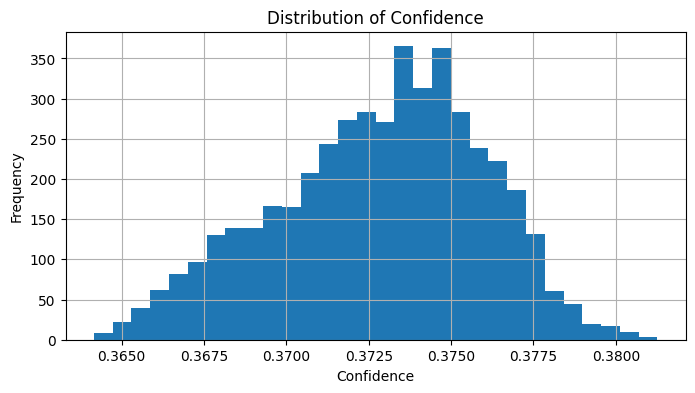

In [37]:
labels_df['confidence'].hist(bins=30, figsize=(8,4))
plt.xlabel("Confidence")
plt.ylabel("Frequency")
plt.title("Distribution of Confidence")
plt.show()


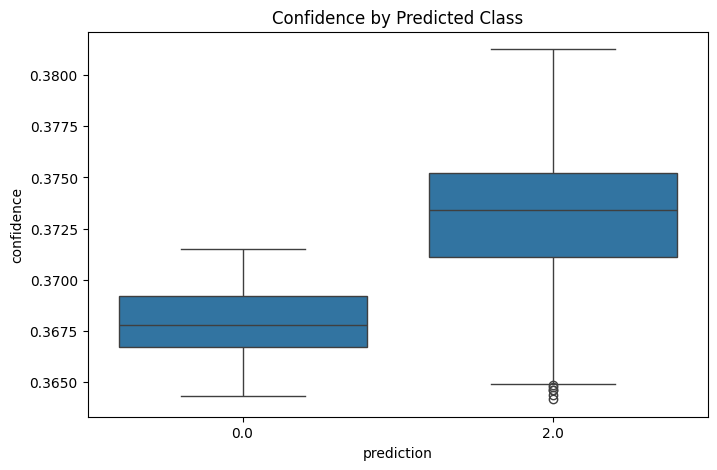

In [38]:
import seaborn as sns

plt.figure(figsize=(8,5))
sns.boxplot(x="prediction", y="confidence", data=labels_df)
plt.title("Confidence by Predicted Class")
plt.show()


In [39]:
labels_df['bin_class'].value_counts(normalize=True)


bin_class
0.0    0.362745
2.0    0.357734
1.0    0.279521
Name: proportion, dtype: float64

In [40]:
labels_df = labels_df.dropna()

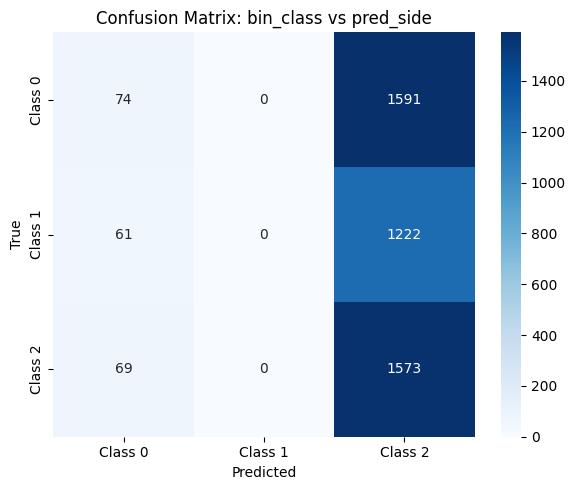

In [41]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# 將類別轉為整數型別
y_true = labels_df["bin_class"].astype(int)
y_pred = labels_df["prediction"].astype(int)

# 計算混淆矩陣
cm = confusion_matrix(y_true, y_pred, labels=[0, 1, 2])
labels = ["Class 0", "Class 1", "Class 2"]

# 繪圖
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix: bin_class vs pred_side")
plt.tight_layout()
plt.show()
